In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from config import data_path
import statsmodels.api as sm

In [2]:
# Load options data, original format
df_option = pd.read_parquet(os.path.join(data_path, 'SPY_options.parquet'))
df_option = df_option[df_option['EXPIRE_DATE'] != '2015-12-19']
df_option = df_option[df_option['EXPIRE_DATE'] != '2018-12-23']
df_option.head()

,QUOTE_DATE,UNDERLYING_LAST,EXPIRE_DATE,DTE,STRIKE,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,C_BID,C_ASK,C_SIZE,...,P_ASK,P_SIZE,P_LAST,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME
0,2010-01-04,113.29,2010-01-15,11.0,55.0,58.3,0.515,58.20,58.40,305 x 270,...,0.02,0 x 1268,0.02,-0.00143,0.00010,0.00074,-0.00435,-0.00050,1.36742,0.0
1,2010-01-04,113.29,2010-01-15,11.0,56.0,57.3,0.506,57.20,57.40,305 x 270,...,0.01,0 x 1269,0.00,-0.00160,0.00020,0.00074,-0.00396,-0.00043,1.33476,NaN
2,2010-01-04,113.29,2010-01-15,11.0,57.0,56.3,0.497,56.20,56.39,305 x 270,...,0.01,0 x 1268,0.03,-0.00146,0.00014,0.00106,-0.00369,-0.00004,1.30655,0.0
3,2010-01-04,113.29,2010-01-15,11.0,58.0,55.3,0.488,55.19,55.40,304 x 269,...,0.03,0 x 1269,0.04,-0.00166,0.00017,0.00056,-0.00428,-0.00051,1.27237,0.0
4,2010-01-04,113.29,2010-01-15,11.0,59.0,54.3,0.479,54.20,54.40,304 x 269,...,0.02,0 x 1268,0.04,-0.00167,0.00016,0.00128,-0.00429,-0.00023,1.24421,0.0


In [3]:
# Load SPY price data
df_stock = pd.read_pickle(os.path.join(data_path, 'spy_1d.pkl'))
df_stock['ts'] = pd.to_datetime(df_stock['ts'].dt.date)
df_stock = df_stock[(df_stock['ts']>='2010-01-01')&(df_stock['ts']<='2022-12-31')]

df_stock.head()

,ts,close_price
2507,2010-01-04,113.330002
2508,2010-01-05,113.629997
2509,2010-01-06,113.709999
2510,2010-01-07,114.190002
2511,2010-01-08,114.570000


In [4]:
# Load squuezemetric data
df_sq = pd.read_csv(os.path.join(data_path, 'sqzme.csv'))
df_sq['date'] = pd.to_datetime(df_sq['date'])
df_sq.tail()

,date,price,dix,gex
3499,2025-03-31,5611.85,0.445360,7.999530e+08
3500,2025-04-01,5633.07,0.493397,1.504443e+09
3501,2025-04-02,5670.97,0.521978,2.134591e+09
3502,2025-04-03,5396.52,0.510583,-1.003998e+09
3503,2025-04-04,5074.08,0.426714,-1.944044e+09


In [5]:
# option filtering
flt_option = df_option.dropna(subset=['C_LAST', 'P_LAST']) # clean NaN value
flt_option = flt_option.rename(columns={'QUOTE_DATE': 'date'})
'''
flt_option = flt_option[flt_option['STRIKE_DISTANCE_PCT'] <= 0.5] # define moneyness of option
flt_option = flt_option[(flt_option['DTE']>=10) &(flt_option['DTE']<=30)] # filter for expiry date
'''

"\nflt_option = flt_option[flt_option['STRIKE_DISTANCE_PCT'] <= 0.5] # define moneyness of option\nflt_option = flt_option[(flt_option['DTE']>=10) &(flt_option['DTE']<=30)] # filter for expiry date\n"

### delta-neutral price using put-call parity

important if we want to do meaningful linear regression of gex related factor

In [6]:
r = 0.03 # or can be pull from other data source
strike = flt_option['STRIKE']
T = flt_option['DTE']/365
call_price = flt_option['C_LAST']
put_price = flt_option['P_LAST']

# calculate delta_neutral for each option price using put call parity
flt_option['delta_neutral_price'] = strike + np.exp(r * T) * (call_price - put_price)

# !! maybe should use SOME KIND OF weighted average approach based on oi or moneyness


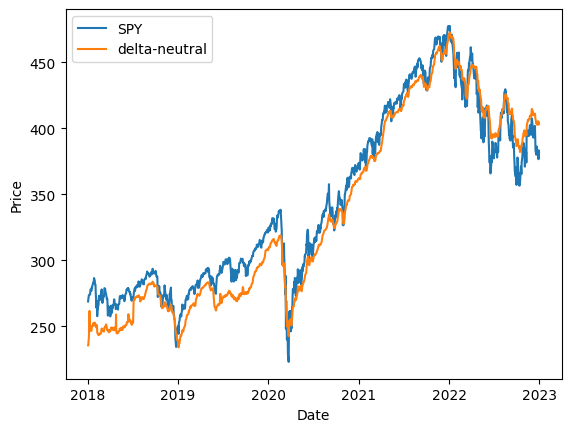

In [7]:
dn_price = flt_option.groupby('date')['delta_neutral_price'].mean().reset_index()
stock_price = df_stock.rename(columns={'ts': 'date'})

# plot spy and delta neutral price
# earliest data: 2010, latest data: 2022
starting_date = '2018-01-01'
ending_date = '2022-12-31'

plt.plot(stock_price[(stock_price['date']>=starting_date)&(stock_price['date']<=ending_date)]['date'], stock_price[(stock_price['date']>=starting_date)&(stock_price['date']<=ending_date)]['close_price'],label='SPY')
plt.plot(dn_price[(dn_price['date']>=starting_date)&(dn_price['date']<=ending_date)]['date'], dn_price[(dn_price['date']>=starting_date)&(dn_price['date']<=ending_date)]['delta_neutral_price'],label='delta-neutral')

plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

calculate gamma exposure (GEX), need oi data. we also have gex from squeezemetric

In [8]:
# open interest. we assume to use volume now
flt_option['C_OI'] = flt_option['C_VOLUME'].fillna(0)
flt_option['P_OI'] = flt_option['P_VOLUME'].fillna(0)

In [9]:
# calculate gamma exposure 
contract_size = 100
flt_option['C_gamma_exposure'] = flt_option['C_GAMMA'] * contract_size * flt_option['C_OI'] * flt_option['UNDERLYING_LAST']**2 * 0.01
flt_option['P_gamma_exposure'] = flt_option['P_GAMMA'] * contract_size * flt_option['P_OI'] * flt_option['UNDERLYING_LAST']**2 * 0.01

call_gamma = flt_option.groupby('date')['C_gamma_exposure'].sum()
put_gamma = flt_option.groupby('date')['P_gamma_exposure'].sum()

gamma_exposure = pd.DataFrame({'GEX': call_gamma - put_gamma,'GEX_Skew': (call_gamma - put_gamma)/(call_gamma + put_gamma)}).reset_index()
gamma_exposure.head()

,date,GEX,GEX_Skew
0,2010-01-04,-1.400059e+06,-0.105897
1,2010-01-05,-2.141322e+06,-0.135393
2,2010-01-06,-3.535363e+06,-0.275775
3,2010-01-07,-2.346442e+06,-0.143924
4,2010-01-08,-2.670400e+06,-0.188442


In [10]:
# squeezemetric gex
gex_sq = df_sq.rename(columns={'gex':'gex_sq'})
gex_sq = gex_sq[['date','gex_sq']]

In [11]:
# time series of date with delta-adjusted and gamma exposure

df_1 = pd.merge(stock_price, dn_price, on='date')
df_1['delta_adjusted'] = df_1['close_price'] - df_1['delta_neutral_price']
df_2 = pd.merge(df_1, gex_sq, on='date')

df_3 = pd.merge(df_2, gamma_exposure, on='date')

df_time = df_3[['date', 'delta_adjusted', 'gex_sq','GEX','GEX_Skew', 'close_price']]

In [14]:
# use latest SPY data

stock_price = pd.read_csv(os.path.join(data_path, 'SPY_10Y_latest.csv'))
stock_price['date'] = pd.to_datetime(stock_price['date'])

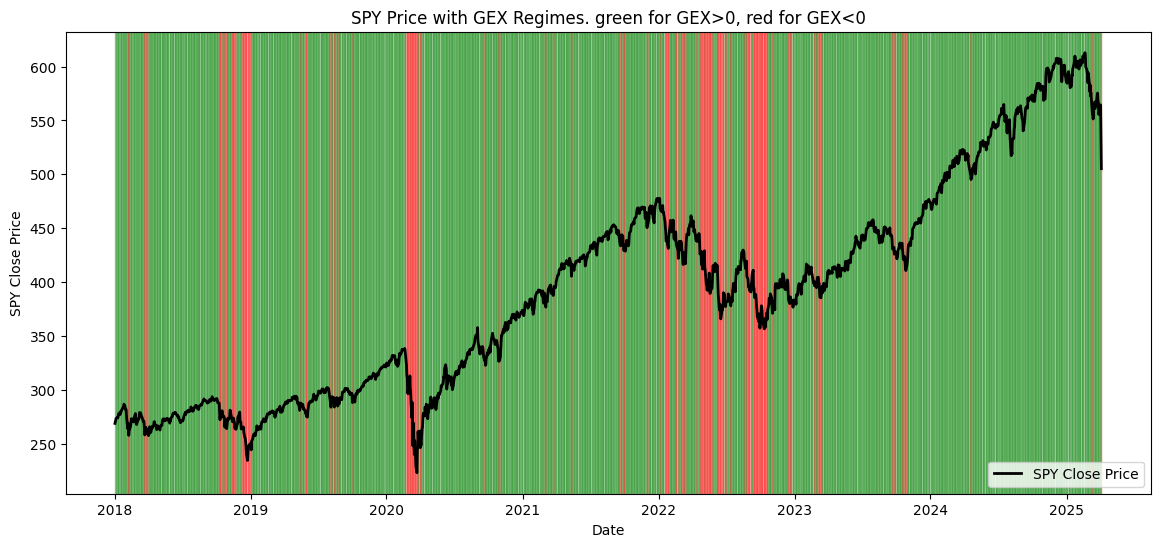

In [15]:
fig, ax = plt.subplots(figsize=(14, 6))

df_time_range = pd.merge(gex_sq,stock_price, on='date')
df_time_range = df_time_range[df_time_range['date']>='2018-01-01']

ax.plot(df_time_range['date'], df_time_range['close_price'], label='SPY Close Price', color='black', linewidth=2)

# Color background: green for GEX > 0, red for GEX < 0
for i in range(1, len(df_time_range)):
    color = 'green' if df_time_range['gex_sq'].iloc[i] > 0 else 'red'
    ax.axvspan(df_time_range['date'].iloc[i-1], df_time_range['date'].iloc[i], color=color, alpha=0.2)

ax.set_title('SPY Price with GEX Regimes. green for GEX>0, red for GEX<0')
ax.set_xlabel('Date')
ax.set_ylabel('SPY Close Price')
ax.legend()
plt.show()


#### we may also study the movement of gex, such as the effects of clustering and mean reverting to understand market regimes

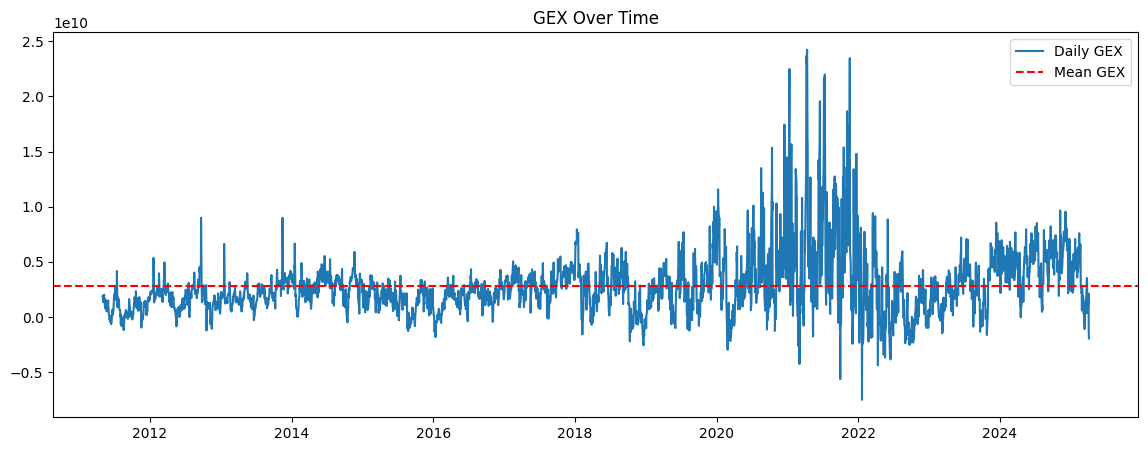

In [16]:
# gex for past 10 year

gex_df = gex_sq[['date','gex_sq']]
gex_df['date'] = pd.to_datetime(gex_df['date'])
gex_df = gex_df.sort_values('date')
gex_df.set_index('date', inplace=True)
plt.figure(figsize=(14, 5))
plt.plot(gex_df['gex_sq'], label='Daily GEX')
plt.axhline(gex_df['gex_sq'].mean(), color='red', linestyle='--', label='Mean GEX')
plt.title('GEX Over Time')
plt.legend()
plt.show()


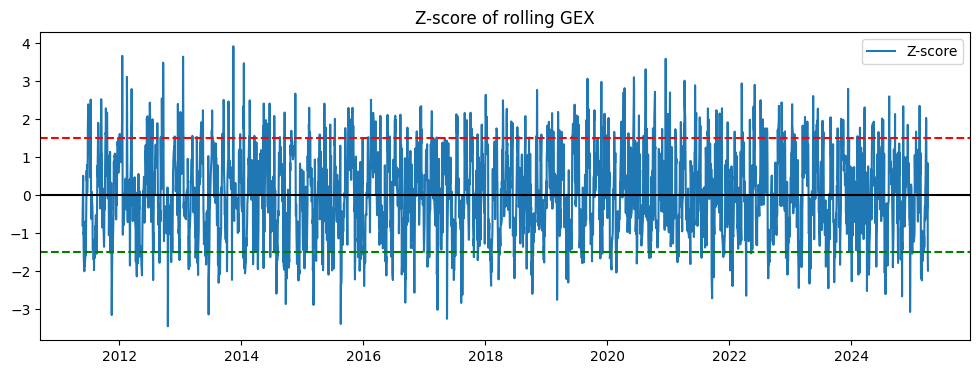

In [17]:
window = 20  # you can try 10, 20, 30, etc.
gex_df['zscore'] = (gex_df['gex_sq'] - gex_df['gex_sq'].rolling(window).mean()) / gex_df['gex_sq'].rolling(window).std()

plt.figure(figsize=(12, 4))
plt.plot(gex_df['zscore'], label='Z-score')
plt.axhline(1.5, color='red', linestyle='--')
plt.axhline(-1.5, color='green', linestyle='--')
plt.axhline(0, color='black', linestyle='-')
plt.legend()
plt.title('Z-score of rolling GEX')
plt.show()

## We understand that GEX may be leading indicator of next day volatility.

Caveat: Volatility has clustering effect. So if same-day GEX and volatility are correlated, that may explain next-day correlation too — not necessarily GEX’s predictive power. 

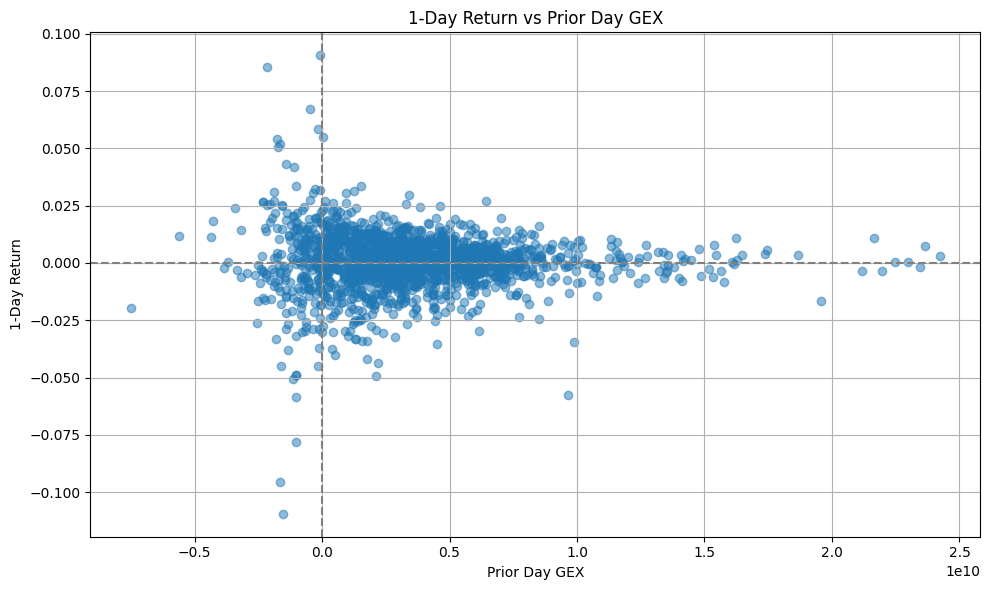

In [18]:
df_time_range = df_time_range[df_time_range['date']>='2016-01-01']
df_time_range.dropna(inplace=True)

df_time_range['1_day_return'] = df_time_range['close_price'] / df_time_range['close_price'].shift(1) - 1

df_time_range['gex_prior'] = df_time_range['gex_sq'].shift(1)


df_time_range.dropna(inplace=True)

plt.figure(figsize=(10, 6))
plt.scatter(df_time_range['gex_prior'], df_time_range['1_day_return'], alpha=0.5)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title('1-Day Return vs Prior Day GEX')
plt.xlabel('Prior Day GEX')
plt.ylabel('1-Day Return')
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
df_vix = pd.read_csv(os.path.join(data_path, 'VIX_History.csv'))
df_vix['date'] = pd.to_datetime(df_vix['DATE'])
df_vix['vix'] = df_vix['CLOSE']/100
df_vix = df_vix[['date','vix']]
df_vix.tail()

,date,vix
3855,2025-03-31,0.2228
3856,2025-04-01,0.2177
3857,2025-04-02,0.2151
3858,2025-04-03,0.3002
3859,2025-04-04,0.4531


In [20]:
stock_price['return'] = stock_price['close_price']/stock_price['close_price'].shift(1) - 1
stock_price['log_return'] = np.log(stock_price['close_price']/stock_price['close_price'].shift(1))
# Realized volatility over 10 days 
stock_price['rv'] = stock_price['log_return'].rolling(window=10).std() * np.sqrt(252)

df_vol = pd.merge(df_vix, stock_price, on='date', how='inner')
vol_gex = pd.merge(df_vol,gex_sq, on='date', how='inner')
vol_gex = vol_gex[['date','vix','rv','gex_sq','return','close_price']]